# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [2]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
import zarr

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [3]:
%%time
expt_ID = 'ND0002'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/NEMO/home/users/dayn/macrohet_nemo/{expt_ID}/'
metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/388620 [00:00<?, ?it/s]

Extracting metadata complete!
CPU times: user 49.9 s, sys: 5.66 s, total: 55.5 s
Wall time: 3min 34s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0103K1F1P1R1,Ok,r01c03f01p01-ch1sk1fk1fl1.tiff,1,3,1,1,0,1,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.49+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
1,0103K1F1P1R2,Ok,r01c03f01p01-ch2sk1fk1fl1.tiff,1,3,1,1,0,2,1,...,-2E-06,0.135466397,0,2023-11-30T17:22:09.723+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
2,0103K1F1P2R1,Ok,r01c03f01p02-ch1sk1fk1fl1.tiff,1,3,1,2,0,1,1,...,0,0.135468394,0,2023-11-30T17:22:10.067+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
3,0103K1F1P2R2,Ok,r01c03f01p02-ch2sk1fk1fl1.tiff,1,3,1,2,0,2,1,...,0,0.135468394,0,2023-11-30T17:22:10.287+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
4,0103K1F1P3R1,Ok,r01c03f01p03-ch1sk1fk1fl1.tiff,1,3,1,3,0,1,1,...,2E-06,0.135470405,0,2023-11-30T17:22:10.627+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388615,0612K150F9P1R2,Ok,r06c12f09p01-ch2sk150fk1fl1.tiff,6,12,9,1,149,2,1,...,-2E-06,0.1351538,268191.66,2023-12-03T20:06:16.08+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388616,0612K150F9P2R1,Ok,r06c12f09p02-ch1sk150fk1fl1.tiff,6,12,9,2,149,1,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.423+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388617,0612K150F9P2R2,Ok,r06c12f09p02-ch2sk150fk1fl1.tiff,6,12,9,2,149,2,1,...,0,0.135155797,268191.66,2023-12-03T20:06:16.657+00:00,488,522,40,1.1,0.1,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."
388618,0612K150F9P3R1,Ok,r06c12f09p03-ch1sk150fk1fl1.tiff,6,12,9,3,149,1,1,...,2E-06,0.135157794,268191.66,2023-12-03T20:06:17+00:00,640,706,40,1.1,0.2,"[[1.000989,0,0,10.0],[0,-1.000989,0,-6.8],[0,0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Define row and column of choice

In [5]:
acq_ID = row, column = (3, 4)

### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [5]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [11]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 1.21 s, sys: 11.2 ms, total: 1.22 s
Wall time: 2.42 s


dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [101]:
%%time
images = images.compute().compute()

CPU times: user 6h 36min 7s, sys: 49min 7s, total: 7h 25min 14s
Wall time: 53min 52s


# Testing ZARR

In [6]:
import zarr

In [7]:
zarr_fn = f'/mnt/NEMO/home/users/dayn/macrohet_nemo/{expt_ID}/acquisition/zarr/{row, column}.zarr'

In [8]:
# Open the Zarr array (assuming it's a single dataset within the Zarr store)
zarr_images = zarr.open(zarr_fn, mode='r')

In [9]:
zarr_images

<zarr.core.Array (150, 2, 3, 6048, 6048) uint16 read-only>

In [11]:
%%time
test = zarr_images[0, 0, 0]

CPU times: user 32.5 s, sys: 58.3 s, total: 1min 30s
Wall time: 6min 44s


In [12]:
test

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 93,  97, 101, ...,  98, 104, 106],
       [101,  99,  98, ..., 105, 105, 108],
       ...,
       [ 99,  97, 103, ..., 107, 101, 104],
       [ 98, 102, 101, ..., 107, 105, 113],
       [104, 103,  96, ..., 102, 106, 113]], dtype=uint16)

In [102]:
viewer = napari.Viewer(title = f'{expt_ID}')

viewer.add_image(images, channel_axis = 1)

[<Image layer 'Image' at 0x7efe5e23c9a0>,
 <Image layer 'Image [1]' at 0x7ef2b8dfbe20>]

In [13]:
print()

# Trying two channel segmentation

In [104]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# model = models.Cellpose(gpu=True, model_type='cyto')
model_path = '/mnt/DATA/macrohet/PS0000/upstream_development/segmentation/cellpose_training/models/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)
def segment(img, diameter = 30, channels = [0,0]):
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels,
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jan 11 13:30:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 30%   38C    P8              33W / 300W |   9319MiB / 49140MiB |      4%      D

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU


>>> GPU activated? YES


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [36]:
img = images[0]

In [106]:
img.shape

(2, 6048, 6048)

In [130]:
rfp_t0 = img[0]
gfp_t0= img[1]

## 2ch segmentation - default model

In [110]:
model = models.CellposeModel(gpu=True, 
                             model_type='cyto'
                             # pretrained_model=model_path
                            )

INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


### Create RGB green/red image of 2ch image

In [111]:
import numpy as np
import matplotlib.pyplot as plt

In [136]:
%%time

# rgb_image = np.zeros((6048, 6048, 3), dtype=img.dtype)

# Assign the first channel of img to the green channel in the RGB image
rgb_image[:, :, 0] = img[0]

# Assign the second channel of img to the red channel in the RGB image
rgb_image[:, :, 1] = img[1]

CPU times: user 2min 29s, sys: 21 s, total: 2min 50s
Wall time: 55.8 s


In [138]:
viewer.add_image(rgb_image)

<Image layer 'rgb_image' at 0x7efff3a09fd0>

In [139]:
%%time
masks, _,_ = model.eval(rgb_image, diameter=None, channels=[2,1],
                                         flow_threshold=0.4, do_3D=False)

CPU times: user 19.4 s, sys: 5.23 s, total: 24.6 s
Wall time: 24.6 s


### Default model of cellpose no way in hell going to work on this

In [140]:
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7ef2b7f48fa0>

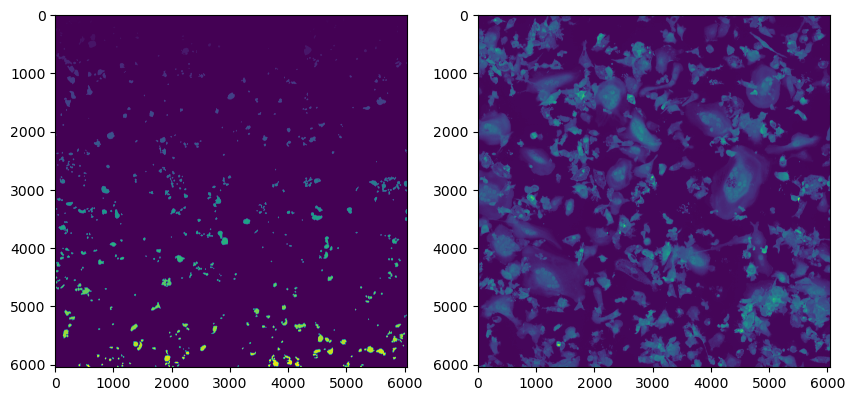

In [141]:
# Plotting the two images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axs[0].imshow(masks)
axs[1].imshow(gfp_t0)

### Trying my previous macrohet cellpose model 

In [150]:
model_path = f'/mnt/DATA/macrohet/PS0000/upstream_development/segmentation/cellpose_training/models'
model_path

'/home/dayn/analysis/models/cellpose/PS0000/macrohet_seg'

In [151]:
model = models.CellposeModel(gpu=True, 
                            pretrained_model=model_path
                            )

INFO:cellpose.models:>>>> loading model /home/dayn/analysis/models/cellpose/PS0000/macrohet_seg
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  188.746 (mean diameter of training ROIs)


In [152]:
viewer.add_image(gfp_t0)

<Image layer 'gfp_t0' at 0x7efe5e527be0>

In [166]:
%%time
masks, _,_ = model.eval(gfp_t0, diameter=None,
                        channels = [0,0],
                        # cellprob_threshold = -3 # didnt do anything noticeable
                        flow_threshold=2.5
                       )

CPU times: user 2min 14s, sys: 51.6 s, total: 3min 5s
Wall time: 2min 1s


In [167]:
viewer.add_labels(masks)

<Labels layer 'masks [2]' at 0x7ef2b8a17d90>

# Testing whole stack

In [ ]:
mask_stack = []
for t, frame in tqdm(enumerate(images), total = 150):
    gfp_frame = frame[1]
    masks, _,_ = model.eval(gfp_frame, diameter=None,
                        channels = [0,0]    
                       )
    # save out mask in case kernel crashes 
    t_fn = f'{t}'.zfill(4)
    fn = f'/mnt/DATA/macrohet/{expt_ID}/upstream_development/segmentation/cellpose/{acq_ID}/t{t_fn}_mphi_model_mask.tif'
    io.imsave(fn, masks)
    mask_stack.append(masks)
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/150 [00:00<?, ?it/s]

/tmp/ipykernel_12803/4010209518.py:10: UserWarning: /mnt/DATA/macrohet/ND0002/upstream_development/segmentation/cellpose/(3, 4)/t0000_mphi_model_mask.tif is a low contrast image
  io.imsave(fn, masks)
/tmp/ipykernel_12803/4010209518.py:10: UserWarning: /mnt/DATA/macrohet/ND0002/upstream_development/segmentation/cellpose/(3, 4)/t0001_mphi_model_mask.tif is a low contrast image
  io.imsave(fn, masks)
/tmp/ipykernel_12803/4010209518.py:10: UserWarning: /mnt/DATA/macrohet/ND0002/upstream_development/segmentation/cellpose/(3, 4)/t0002_mphi_model_mask.tif is a low contrast image
  io.imsave(fn, masks)
/tmp/ipykernel_12803/4010209518.py:10: UserWarning: /mnt/DATA/macrohet/ND0002/upstream_development/segmentation/cellpose/(3, 4)/t0003_mphi_model_mask.tif is a low contrast image
  io.imsave(fn, masks)
/tmp/ipykernel_12803/4010209518.py:10: UserWarning: /mnt/DATA/macrohet/ND0002/upstream_development/segmentation/cellpose/(3, 4)/t0004_mphi_model_mask.tif is a low contrast image
  io.imsave(fn, ma

In [ ]:
viewer.add_image(mask_stack)

### Load masks

In [18]:
mask_stack = []
# load masks 
for t, frame in tqdm(enumerate(images), total = 150):
    # gfp_frame = frame[1]
    # masks, _,_ = model.eval(gfp_frame, diameter=None,
    #                     channels = [0,0]    
    #                    )
    # # save out mask in case kernel crashes 
    t_fn = f'{t}'.zfill(4)
    fn = f'/mnt/DATA/macrohet/{expt_ID}/upstream_development/segmentation/cellpose/{acq_ID}/t{t_fn}_mphi_model_mask.tif'
    masks = io.imread(fn)
    mask_stack.append(masks)
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/150 [00:00<?, ?it/s]

In [19]:
viewer = napari.Viewer()

viewer.add_labels(mask_stack)

<Labels layer 'mask_stack' at 0x7efa712f8340>

# Test track

In [ ]:
import 